# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import LabelEncoder
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool
import boto3
import os
from dotenv import load_dotenv

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [13]:
tracks = pd.read_parquet("./tracks.parquet")
catalog_names = pd.read_parquet("./catalog_names.parquet")
interactions = pd.read_parquet("./interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [5]:
tracks.sample(5, random_state=42).sort_values("track_id").set_index("track_id")

,albums,artists,genres
track_id,,,
518436,"[55672, 55673, 4497446, 4497447, 4497448, 4497...","[29903, 322, 316, 321, 319, 320]",[68]
700056,[37164],[118708],"[7, 112, 61]"
34625231,[4271134],[4732313],[68]
39019190,[1806703],[2720477],[12]
95229664,[19388714],[222689],[11]


In [6]:
tracks.isnull().sum().sort_values(ascending=False)

track_id    0
albums      0
artists     0
genres      0
dtype: int64

In [7]:
tracks.duplicated(subset=["track_id"], keep=False).sum()

0

In [8]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [9]:
catalog_names.sample(5, random_state=42).sort_values("id").set_index("id")

,type,name
id,,
8810199,album,Shadow
19044912,album,Gnomi Di Natale
43503873,track,Пароль
51822590,track,Музыка в фильмах Тарантино
95436616,track,Ключ


In [10]:
catalog_names.isnull().sum().sort_values(ascending=False)

id      0
type    0
name    0
dtype: int64

In [11]:
catalog_names.duplicated(subset=["id"], keep=False).sum()

70418

In [12]:
catalog_names[catalog_names.duplicated(subset=["id"], keep=False)]

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack
...,...,...,...
1141043,21314698,track,No Good For You
1141108,21320653,track,Oh!
1141114,21321251,track,Lady in Red
1141142,21327491,track,Waiting Here


In [13]:
catalog_names.query("id == 12")

,id,type,name
1,12,album,Wild Young Hearts
658728,12,artist,Phil Everly
812317,12,genre,shanson


In [ ]:
catalog_names.duplicated(subset=["id", "type"], keep=False).sum()

0

In [15]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [16]:
interactions.sample(5, random_state=42).sort_values("user_id").set_index(["user_id", "track_id"])

,,track_seq,started_at
user_id,track_id,,
73981,48591660,527,2022-09-26
78605,732405,10,2022-09-14
844258,3581309,131,2022-06-05
1091434,14937363,434,2022-06-29
1273064,40339506,1203,2022-08-24


In [17]:
interactions.isnull().sum().sort_values(ascending=False)

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

In [18]:
interactions.duplicated(subset=["user_id", "track_id"], keep=False).sum()

0

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

1) Данные выглядят реалистично, пропуски и дублирования в данных отсутствуют (не считая catalog_names, но там данные определяются колонкой "type");
2) Корректирующие действия не требуются.

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

Распределение уникальных пользователей и прослушиваний по месяцам

In [3]:
interactions["started_at_month"] = pd.to_datetime(interactions["started_at"]).dt.to_period('M').dt.to_timestamp().dt.date

In [ ]:
interactions_by_month_events = interactions.groupby("started_at_month").agg(events=("started_at", 'count')).reset_index()

: 

In [ ]:
interactions_by_month_users = interactions.groupby("started_at_month").agg(users=("user_id", 'nunique')).reset_index()

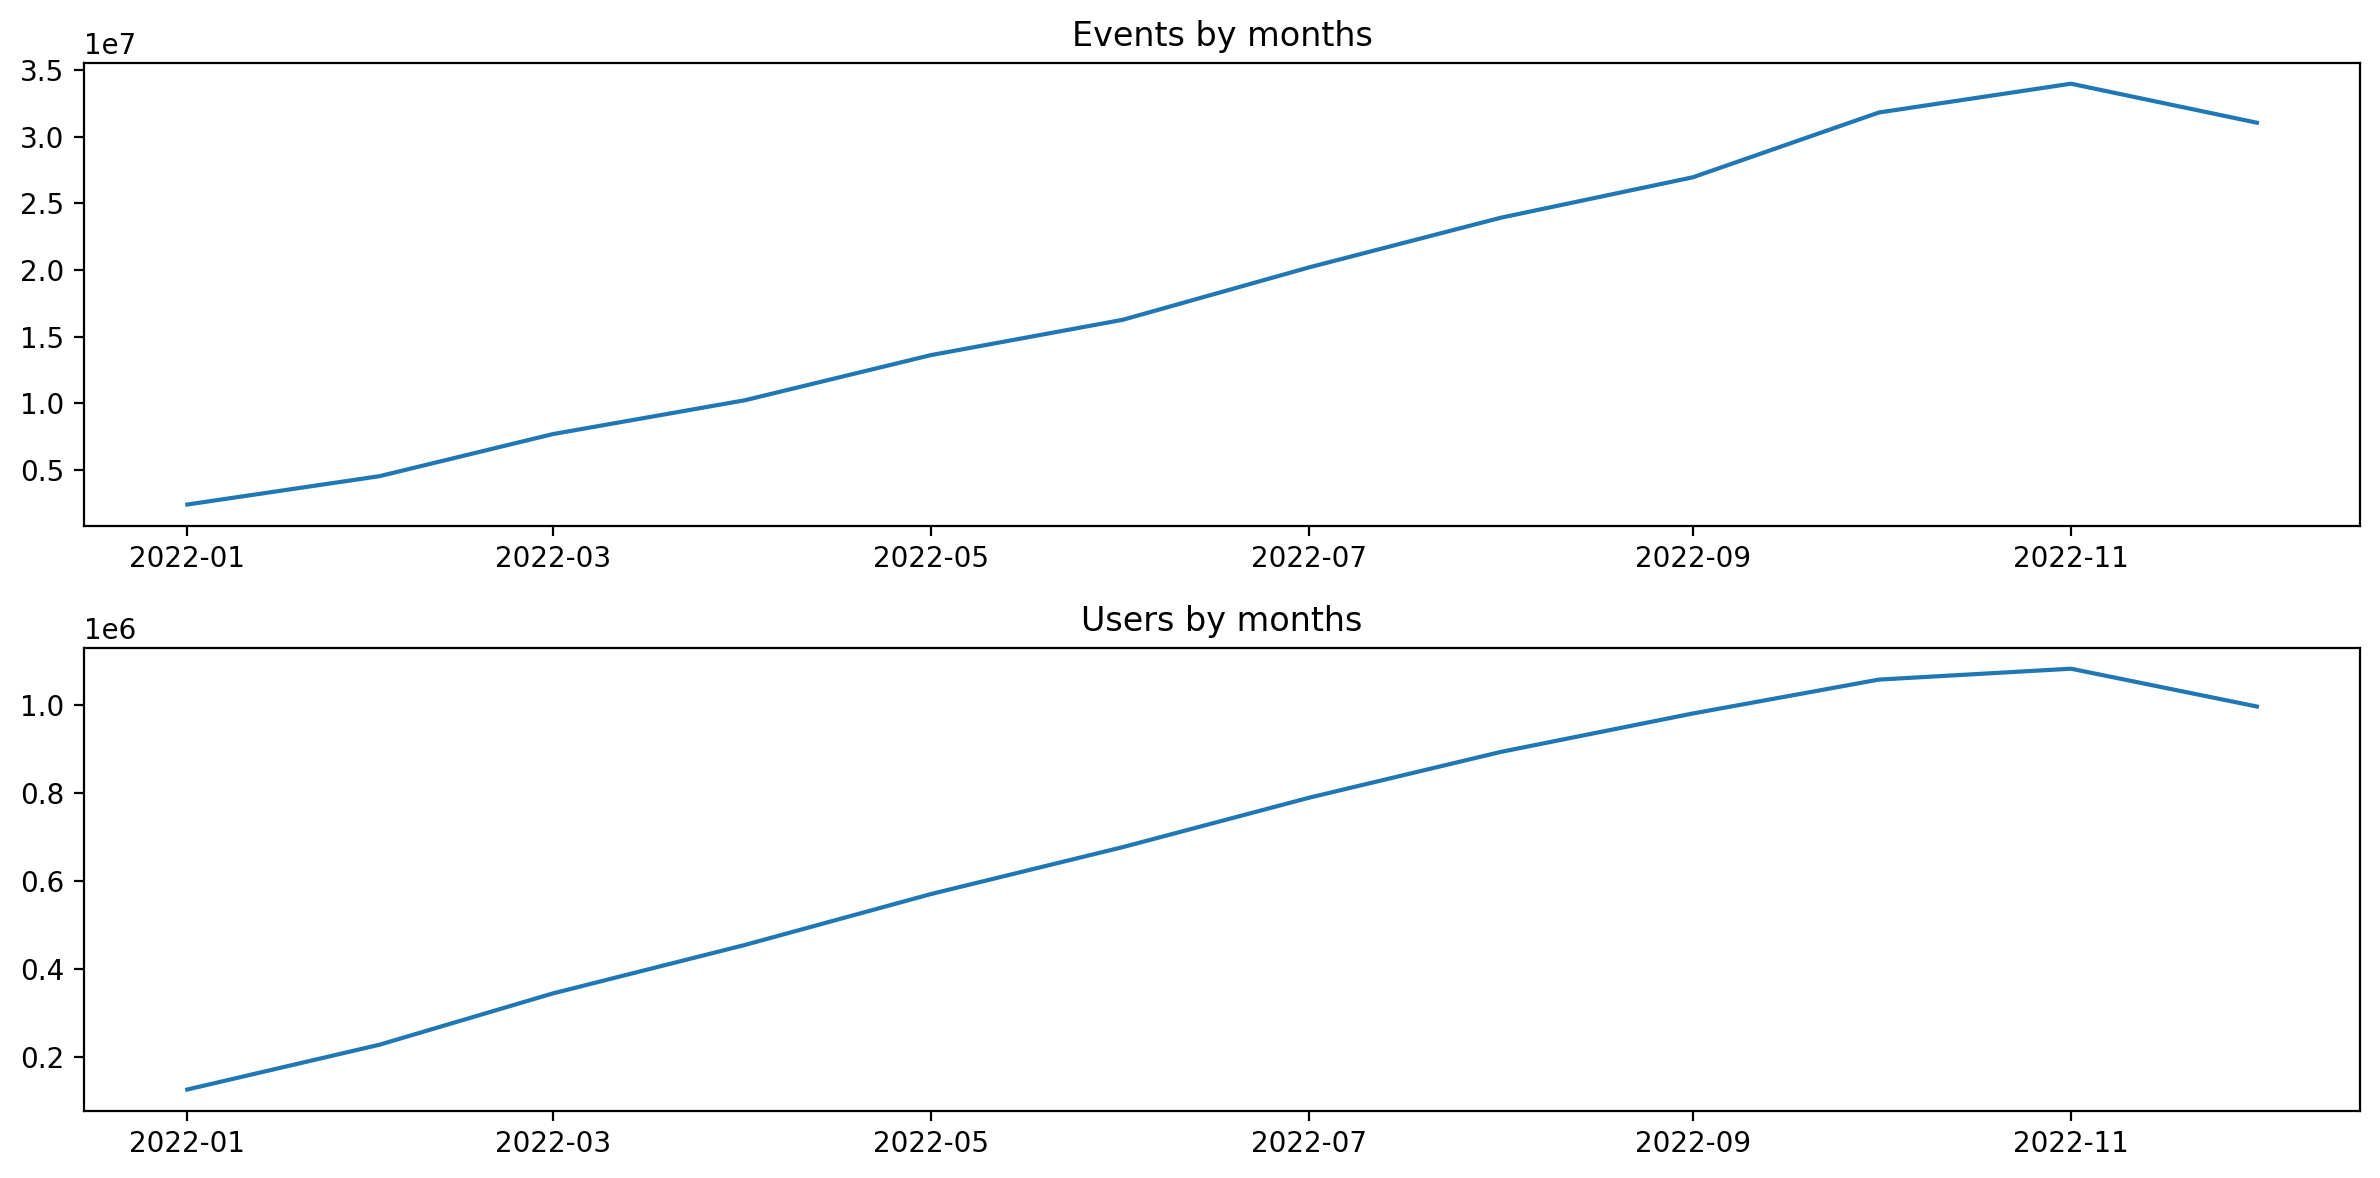

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(interactions_by_month_events["started_at_month"], interactions_by_month_events["events"])
ax.set_title("Events by months")

ax = axs[1]
ax.plot(interactions_by_month_users["started_at_month"], interactions_by_month_users["users"])
ax.set_title("Users by months")

fig.tight_layout()

Распредление пользователей и треков по количеству прослушиваний

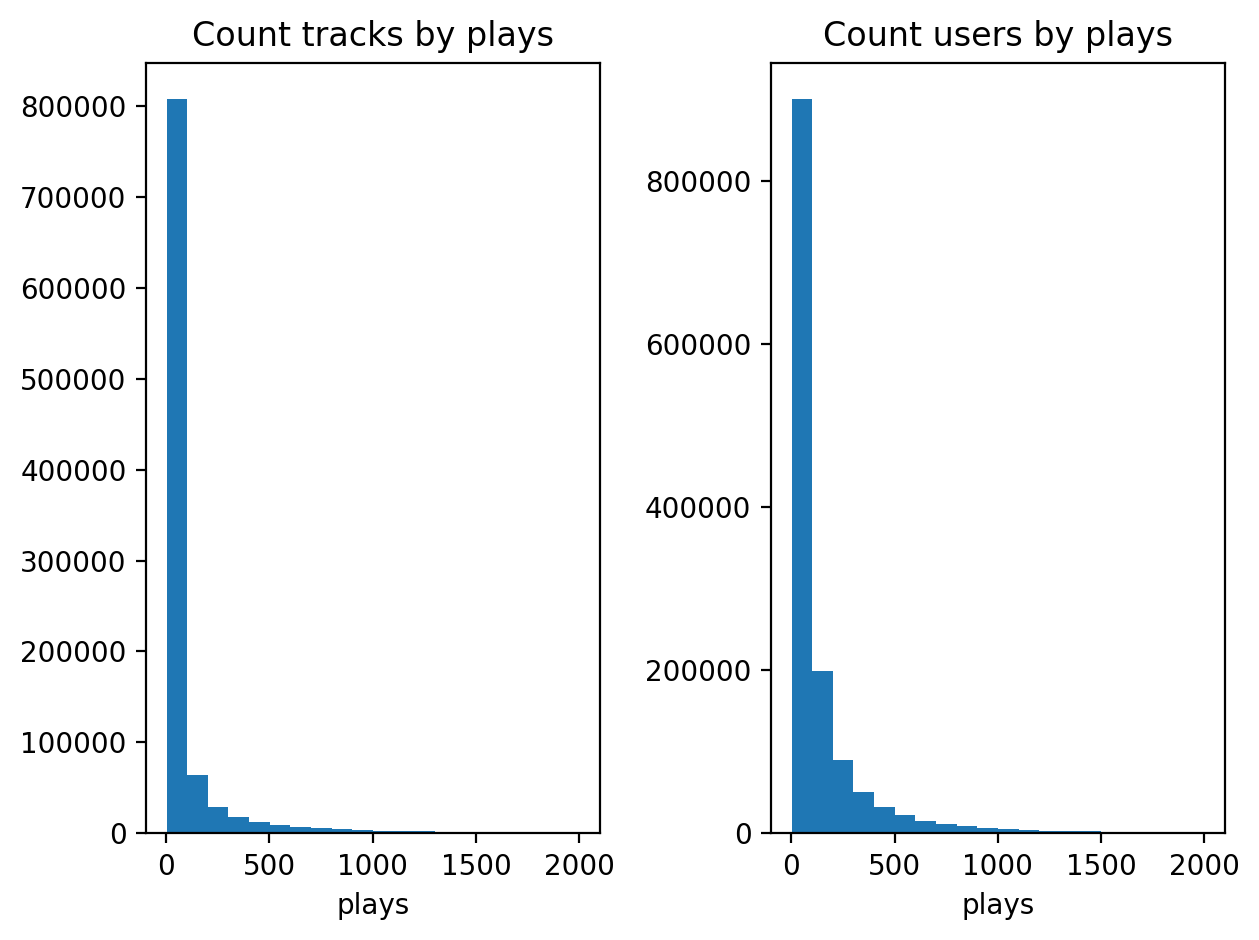

In [ ]:
#Ограничимся 2000 воспроизведениями, чтобы данные были нагляднее

dist1 = interactions.groupby("track_id").agg(count_plays=("user_id", 'count')) \
    .query("count_plays < 2000").sort_values("count_plays")
dist2 = interactions.groupby("user_id").agg(count_plays=("track_id", 'count')) \
    .query("count_plays < 2000").sort_values("count_plays")

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(dist1, bins=20)
axs[1].hist(dist2, bins=20)

axs[0].title.set_text("Count tracks by plays")
axs[0].set_xlabel("plays")
axs[1].title.set_text("Count users by plays")
axs[1].set_xlabel("plays")

plt.show()

Наиболее популярные треки

In [ ]:
# рассчитаем количество пользователей прослушавших трек и отсортируем по прослушиваниям
tracks_top = interactions.groupby("track_id").agg(plays=("user_id", 'count')).reset_index() \
    .sort_values("plays", ascending=False)

# возьмем топ 100 и добавим к датасету данные о треке
top_100_tracks = catalog_names.loc[catalog_names["id"].isin(tracks_top["track_id"].head(100))] \
    .query("type == 'track'") \
    .rename(columns={"id": "track_id"}) \
    .merge(tracks_top, on="track_id") \
    .sort_values("plays", ascending=False).reset_index(drop=True)
    
top_100_tracks

,track_id,type,name,plays
0,53404,track,Smells Like Teen Spirit,111062
1,33311009,track,Believer,106921
2,178529,track,Numb,101924
3,35505245,track,I Got Love,99490
4,65851540,track,Юность,86670
...,...,...,...,...
95,3616433,track,Summertime Sadness,51416
96,628970,track,I Hate Everything About You,50262
97,27032843,track,Shut Your Mouth,50189
98,9282507,track,Родина,49932


Наиболее популярные жанры

In [ ]:
top_100_tracks = top_100_tracks.merge(tracks[["track_id", "genres"]], on="track_id")

In [ ]:
def get_genres(items):

    """ 
    извлекает список жанров по каждому треку, 
    подсчитывает суммарное количество каждого из них
    с учетом места в рейтинге
    """
    
    genres_counter = {}

    for i, s, in items.iterrows():
        genres = s["genres"]
        for genre in genres:
            try:
                genres_counter[genre] += 1 - i / len(items)
            except KeyError:
                genres_counter[genre] = 1 - i / len(items)

    genres = pd.Series(genres_counter, name="count")
    genres = genres.to_frame().reset_index().rename(columns={"index": "genre_id"}) \
        .sort_values("count", ascending=False)

    return genres

In [ ]:
# подсчитаем частоту появления жанров в топе
genres = get_genres(top_100_tracks)

In [ ]:
genres.head(5)

,genre_id,count
7,11,15.01
2,102,12.75
8,20,10.51
1,14,9.31
9,70,5.69


In [ ]:
# соединим id жанров с их названиями и выведем топ 10
top_10_genres = catalog_names.loc[catalog_names["id"].isin(genres["genre_id"].head(10))] \
    .query("type == 'genre'") \
    .rename(columns={"id": "genre_id"}) \
    .merge(genres[["genre_id", "count"]], on="genre_id") \
    .sort_values("count", ascending=False).reset_index(drop=True)
    
top_10_genres

,genre_id,type,name,count
0,11,genre,pop,15.01
1,102,genre,allrock,12.75
2,20,genre,ruspop,10.51
3,14,genre,rock,9.31
4,70,genre,indie,5.69
5,75,genre,rap,4.75
6,16,genre,dance,4.58
7,13,genre,alternative,3.85
8,3,genre,rusrap,3.78
9,68,genre,electronics,3.09


Треки, которые никто не прослушал

In [ ]:
catalog_names.loc[~catalog_names["id"].isin(interactions["track_id"])].query("type == 'track'")
#Таких треков не обнаружено

,id,type,name


Проверим, что каждый трек прослушан хотя бы один раз

In [ ]:
interactions["track_id"].nunique() == len(catalog_names.query("type == 'track'")["id"])

True

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [ ]:
# добавим названия треков
tracks = catalog_names.query("type == 'track'").rename(columns={"id": "track_id"}).merge(tracks, on="track_id", how='right').drop(columns="type")

In [5]:
items = tracks.copy()
events = interactions.copy()

In [6]:
items.rename(columns={"track_id": "item_id"}, inplace=True)
events.rename(columns={"track_id": "item_id"}, inplace=True)

In [ ]:
# перекодируем item_id
item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events["item_id_enc"] = item_encoder.transform(events["item_id"])

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [8]:
items.to_parquet("items.parquet")

In [9]:
events.to_parquet("events.parquet")

Зададим переменные окружения для выгрузки данных в S3 bucket и создадим подключение

In [10]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
bucket_name = os.getenv("S3_BUCKET_NAME")
url = 'https://storage.yandexcloud.net'

session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name="ru-central1",
)

s3_client = session.client(
    service_name='s3',
    endpoint_url=url   
)

In [11]:
s3_client.upload_file(Filename='items.parquet', Bucket=bucket_name, Key='recsys/data/items.parquet')

In [12]:
s3_client.upload_file(Filename='events.parquet', Bucket=bucket_name, Key='recsys/data/events.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

После выполнения ячейки ниже и перезапуска ядра - необходимо вновь импортировать библиотеки (ячейка 1), далее продолжать с этапа 3

In [13]:
del tracks
del interactions

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [3]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
bucket_name = os.getenv("S3_BUCKET_NAME")
url = 'https://storage.yandexcloud.net'

session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name="ru-central1",
)

s3_client = session.client(
    service_name='s3',
    endpoint_url=url   
)

In [4]:
s3_client.download_file(Bucket=bucket_name, Key='recsys/data/items.parquet', Filename="items.parquet")

In [16]:
s3_client.download_file(Bucket=bucket_name, Key='recsys/data/events.parquet', Filename="events.parquet")

In [2]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [3]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-01")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train) & set(users_test)

print(len(users_train), len(users_test), len(common_users)) 

1294970 995485 917234


In [ ]:
cold_users = users_test[~users_test.isin(users_train)]

print(len(cold_users))

78251


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [ ]:
top_pop_start_date = pd.to_datetime("2022-11-01") # популярные за последний месяц

# рассчитываем количество пользователей прослушавших каждый трек и отсортируем
tracks_top = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby("item_id").agg(plays=("user_id", 'count')).reset_index() \
    .sort_values("plays", ascending=False)

# возьмем топ 100 и добавим к датасету данные о треке
top_100_tracks = items.loc[items["item_id"].isin(tracks_top["item_id"].head(100))] \
    .merge(tracks_top, on="item_id") \
    .sort_values("plays", ascending=False).reset_index(drop=True)
    
top_100_tracks["name"]

0     Blinding Lights
1              Юность
2           Rampampam
3              Птичка
4          In The End
           ...       
95               STAY
96                X.O
97              Пушка
98            Свобода
99           По кайфу
Name: name, Length: 100, dtype: object

In [17]:
top_100_tracks.to_parquet("top_popular.parquet")

In [5]:
s3_client.upload_file(Filename='top_popular.parquet', Bucket=bucket_name, Key='recsys/recommendations/top_popular.parquet')

# Персональные

Рассчитаем персональные рекомендации.

In [ ]:
# создаём sparse-матрицу формата CSR для экономии памяти
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["track_seq"],
    (events_train['user_id'], events_train['item_id_enc'])),
    dtype=np.int8) 

Обучаем ALS-модель на построенной матрице

In [5]:
als_model = AlternatingLeastSquares(factors=10, iterations=10, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle-recsys-project/.venv_recsys-project/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 10/10 [05:02<00:00, 30.24s/it]


In [ ]:
# повторно определим кодировщик для обратного перекодирования рекоммендаций
item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])

LabelEncoder()

In [23]:
def get_recommendations_als(user_item_matrix, model, user_id, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    recommendations = model.recommend(
         user_id, 
         user_item_matrix[user_id], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [ ]:
# определим матрицу для тестирования
user_item_matrix_test = scipy.sparse.csr_matrix((
    events_test["track_seq"],
    (events_test['user_id'], events_test['item_id_enc'])),
    dtype=np.int8) 

In [25]:
get_recommendations_als(user_item_matrix_test, als_model, 4, include_seen=True)

,item_id_enc,score,item_id
0,9098,0.771684,53404
1,23706,0.749681,148345
2,29336,0.740149,214489
3,15643,0.727186,96089
4,26232,0.719002,170051


In [ ]:
# получаем список всех возможных user_id из events_train
user_ids = events_train["user_id"].unique()

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids, 
    user_item_matrix_train[user_ids], 
    filter_already_liked_items=True, N=5)

In [29]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id": user_ids,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

KeyError: 0

In [12]:
# получаем изначальные идентификаторы
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns="item_id_enc")

In [ ]:
als_recommendations.to_parquet("personal_als.parquet")

In [7]:
s3_client.upload_file(Filename="personal_als.parquet", Bucket=bucket_name, Key='recsys/recommendations/personal_als.parquet')

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [ ]:
# получим перекодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

max_similar_items = 5

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()
})
similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2") 

In [35]:
similar_items.to_parquet("similar.parquet")

In [8]:
s3_client.upload_file(Filename="similar.parquet", Bucket=bucket_name, Key='recsys/recommendations/similar.parquet')

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [4]:
def get_user_features(event):
    
    """ считает пользовательские признаки """
    
    user_features = event.groupby("user_id").agg(
        listening_period=("started_at", lambda x: (x.max()-x.min()).days),
        tracks_listened=("item_id", "count")
    )
    
    user_features["tracks_per_month"] = user_features["tracks_listened"] / (user_features["listening_period"] / 30)
    
    return user_features


In [5]:
user_features_for_train = get_user_features(events_train)
user_features_for_train

,listening_period,tracks_listened,tracks_per_month
user_id,,,
0,60,26,13.000000
1,47,36,22.978723
2,137,14,3.065693
3,266,31,3.496241
4,245,231,28.285714
...,...,...,...
1374578,115,7,1.826087
1374579,62,24,11.612903
1374580,209,277,39.760766


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [5]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-15")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

In [4]:
# загружаем рекомендации от базового генератора
als_recommendations = pd.read_parquet("personal_als.parquet")

In [ ]:
# добавляем сгенерированные признаки в датасет
candidates = pd.merge(
    als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    user_features_for_train,
    on="user_id",
    how="left")

In [79]:
candidates

,user_id,item_id,als_score,listening_period,tracks_listened,tracks_per_month
0,0,17352611,0.057886,60,26,13.000000
1,0,16549426,0.056918,60,26,13.000000
2,0,14690772,0.056086,60,26,13.000000
3,0,17902234,0.055668,60,26,13.000000
4,0,14701552,0.055187,60,26,13.000000
...,...,...,...,...,...,...
6474845,1374582,49961817,1.276944,23,132,172.173913
6474846,1374582,50834580,1.249963,23,132,172.173913
6474847,1374582,50821247,1.225635,23,132,172.173913
6474848,1374582,52380688,1.201966,23,132,172.173913


In [9]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных 

events_labels["target"] = 1
candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"], how="left")
candidates["target"] = candidates["target"].fillna(0).astype("int")

# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_for_train = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [10]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'listening_period', 'tracks_listened', 'tracks_per_month']
target = 'target'

# создаем Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6655506	total: 62.6ms	remaining: 1m 2s
100:	learn: 0.5512136	total: 599ms	remaining: 5.33s
200:	learn: 0.5459864	total: 1.16s	remaining: 4.6s
300:	learn: 0.5415568	total: 1.72s	remaining: 4s
400:	learn: 0.5379347	total: 2.31s	remaining: 3.45s
500:	learn: 0.5346329	total: 2.86s	remaining: 2.85s
600:	learn: 0.5318948	total: 3.42s	remaining: 2.27s
700:	learn: 0.5290690	total: 3.97s	remaining: 1.69s
800:	learn: 0.5264784	total: 4.54s	remaining: 1.13s
900:	learn: 0.5240651	total: 5.09s	remaining: 560ms
999:	learn: 0.5219935	total: 5.65s	remaining: 0us


Подготовим данные для инференса

In [4]:
# составим актуальные рекоммендации на основе последних трех месяцев, для уменьшения нагрузки на систему
inference_global_time_split_date = pd.to_datetime("2022-09-01")
split_date_for_inference_idx = events_train["started_at"] > inference_global_time_split_date
events_train = events_train[split_date_for_inference_idx].copy()

In [6]:
events_inference = pd.concat([events_train, events_labels])

In [7]:
# оставим только тех пользователей, что есть в тесте, для экономии ресурсов
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"])]

In [9]:
user_features_for_ranking = get_user_features(events_inference)

In [10]:
user_features_for_ranking.to_parquet("user_features_rank.parquet")

Обучаем ALS модель на данных для инференса 

In [10]:
user_item_matrix_inference = scipy.sparse.csr_matrix((
    events_inference["track_seq"],
    (events_inference['user_id'], events_inference['item_id_enc'])),
    dtype=np.int8)

In [12]:
als_model = AlternatingLeastSquares(factors=10, iterations=10, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_inference)

/home/mle-user/mle-recsys-project/.venv_recsys-project/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
user_ids = events_inference["user_id"].unique()

als_recommendations_inference = als_model.recommend(
    user_ids, 
    user_item_matrix_inference[user_ids], 
    filter_already_liked_items=True, N=5)

# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations_inference[0]
als_scores = als_recommendations_inference[1]

als_recommendations_inference = pd.DataFrame({
    "user_id": user_ids,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations_inference = als_recommendations_inference.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations_inference["item_id_enc"] = als_recommendations_inference["item_id_enc"].astype("int")
als_recommendations_inference["score"] = als_recommendations_inference["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations_inference["item_id"] = item_encoder.inverse_transform(als_recommendations_inference["item_id_enc"])
als_recommendations_inference = als_recommendations_inference.drop(columns="item_id_enc")

als_recommendations_inference.to_parquet("personal_als_inference.parquet")

In [12]:
s3_client.upload_file(Filename="personal_als_inference.parquet", Bucket=bucket_name, Key='recsys/recommendations/personal_als_inference.parquet')

In [11]:
# восстановим данные
als_recommendations_inference = pd.read_parquet("personal_als_inference.parquet")
user_features_for_ranking = pd.read_parquet("user_features_rank.parquet")

In [12]:
candidates_to_rank = pd.merge(
    als_recommendations_inference[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    user_features_for_ranking,
    on="user_id",
    how="left"
)

In [ ]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

max_recommendations_per_user = 5
final_recommendations = candidates_to_rank.groupby("user_id").head(max_recommendations_per_user)

In [14]:
final_recommendations.to_parquet("recommendations.parquet")

In [10]:
s3_client.upload_file(Filename="recommendations.parquet", Bucket=bucket_name, Key='recsys/recommendations/recommendations.parquet')

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

Загрузим данные и определим функции

In [18]:
top_pop = pd.read_parquet("top_popular.parquet")

In [ ]:
als_recommendations = pd.read_parquet("personal_als.parquet")

In [8]:
final_recommendations = pd.read_parquet("recommendations.parquet")

In [ ]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth) - треки прослушанные пользователем
    - pr (prediction) - рекомендации
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [ ]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall 

Рассчитаем метрики для топа популярных

In [ ]:
# подготовим данные для рассчета в функциях
top_pop = top_pop.merge(events_train[["user_id", "item_id"]], on="item_id", how='left')

In [23]:
top_pop.rename(columns={"plays": "score"}, inplace=True)

In [ ]:
top_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    top_pop, 
    top_k=5)

/tmp/ipykernel_2652/1061002411.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 431509


In [37]:
top_precision, top_recall = compute_cls_metrics(top_recs_for_binary_metrics)

In [26]:
cov_items_top = top_pop["item_id"].nunique()/items["item_id"].nunique()

Рассчитаем метрики для ALS-модели

In [ ]:
als_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    als_recommendations, 
    top_k=5)

In [ ]:
als_precision, als_recall = compute_cls_metrics(als_recs_for_binary_metrics)

In [ ]:
cov_items_als = als_recommendations["item_id"].nunique()/items["item_id"].nunique()

Рассчитаем метрики для финальной модели

In [10]:
final_recommendations.rename(columns={"cb_score": "score"}, inplace=True)

In [11]:
fin_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  events_inference,
    events_test_2, 
    final_recommendations, 
    top_k=5)

Common users: 768558


In [14]:
fin_precision, fin_recall = compute_cls_metrics(fin_recs_for_binary_metrics)

In [15]:
cov_items_fin = final_recommendations["item_id"].nunique()/items["item_id"].nunique()

Поскольку рассчет рекомендаций производился только для айтемов, с которыми пользователь ранее не взаимодействовал (флаг - "filter_already_liked_items=True") для экономии ресурсов - то оценка рекомендаций по новизне неинформативна

In [ ]:
# разметим каждую рекомендацию признаком listen
events_train["listen"] = True
als_recommendations = als_recommendations.merge(events_train[["listen", "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
als_recommendations["listen"] = als_recommendations["listen"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values("score", ascending=False)
als_recommendations["listen"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5_als = (1-als_recommendations.query("rank <= 5").groupby("user_id")["listen"].mean())

# посчитаем средний novelty
novelty_5_als.mean()

/tmp/ipykernel_2388/3506993917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["read"] = True


: 

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [ ]:
print(f"Метрики рекомендаций популярного:\n\
    precision: {top_precision};\n\
    recall: {top_recall};\n\
    coverage: {cov_items_top}")

Метрики рекомендаций популярного:
    precision: 0.0;
    recall: 0.0;
    coverage: 0.0001


In [ ]:
print(f"Метрики ALS-рекомендаций:\n\
    precision: {als_precision:.3f};\n\
    recall: {als_recall:.3f};\n\
    coverage: {cov_items_als:.3f}")

Метрики ALS-рекомендаций:
    precision: 0.003;
    recall: 0.002;
    coverage: 0.003


In [17]:
print(f"Метрики финальной модели ранжирования:\n\
    precision: {fin_precision:.4f};\n\
    recall: {fin_recall:.4f};\n\
    coverage: {cov_items_fin:.4f}")

Метрики финальной модели ранжирования:
    precision: 0.0024;
    recall: 0.0025;
    coverage: 0.0022


# Выводы
- Треки прослушанные пользователем за последний месяц не совпали с топом популярных (построенном на основе ноябрьских прослушиваний).
- Метрики ALS-рекомендаций немногим выше метрик финальной модели - это, вероятно, связано с тем, что для инференса была взята лишь часть данных из "events_train".
- Метрики в целом имеют не очень высокие показатели - это, в свою очередь, связано с тем, что для рекомендаций отбирался лишь топ 5 треков (для ускорения рассчетов). Для рассчета большего числа рекомендаций на пользователя требуются бОльшие мощности, либо уменьшение тренировочной выборки (скажем - рекоммендации за последнии 30 дней), как это было сделано с финальной моделью.